# Подготовка

Импортируем модули

In [68]:
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm

import random
import os

Проверим версии импортированных пакетов, посмотрим на параметры GPU

In [40]:
print(f'torch.__version__ = {torch.__version__}')
print(f'torchvision.__version__ = {torchvision.__version__}')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device = {device} \n')

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(f'{gpu_info}')

torch.__version__ = 2.3.1+cu121
torchvision.__version__ = 0.18.1+cu121
device = cuda 

Tue Aug  6 08:43:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0              30W /  70W |    481MiB / 15360MiB |      0%      Default |
|                                         |                      |     

Зафиксируем seed для воспроизводимости

In [69]:
def seed_everything(seed):
    random.seed(seed) # фиксируем генератор случайных чисел
    os.environ['PYTHONHASHSEED'] = str(seed) # фиксируем заполнения хешей
    np.random.seed(seed) # фиксируем генератор случайных чисел numpy
    torch.manual_seed(seed) # фиксируем генератор случайных чисел pytorch
    torch.cuda.manual_seed(seed) # фиксируем генератор случайных чисел для GPU
    torch.backends.cudnn.deterministic = True # выбираем только детерминированные алгоритмы (для сверток)
    torch.backends.cudnn.benchmark = False # фиксируем алгоритм вычисления сверток

seed_everything(42)

Подготовим даталоадер для обучающего и тестового датасета. В качестве датасета будем использовать CIFAR10

In [70]:
def load(transform_train, transform_val, batch_size=64):
    # Training dataset and loader
    training_set = torchvision.datasets.CIFAR10('./cifar10', train=True, transform=transform_train, download=True)
    training_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)

    # Test dataset and loader
    validation_set = torchvision.datasets.CIFAR10('./cifar10', train=False, transform=transform_val, download=True)
    validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False)


    # Report split sizes
    print('Training set has {} instances'.format(len(training_set)))
    print('Validation set has {} instances'.format(len(validation_set)))

    return training_loader, validation_loader

Функция для визуализация одного батча

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

def show_batch(loader):
    dataiter = iter(loader)
    images, labels = next(dataiter)

    # Create a grid from the images and show them
    img_grid = torchvision.utils.make_grid(images)
    matplotlib_imshow(img_grid, one_channel=False)

Инициализируем модель, функцию потерь и оптимизатор

In [43]:
model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

Опишем цикл обучения

In [71]:
def train(model, trainloader, criterion, optimizer):

    model.train()

    fc_gradients = []

    for step, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        if step % 100 == 0:
          print(f'Step: {step}, Loss: {loss}')

        fc_gradients.append(model.fc.weight.grad.mean().item())

Опишем цикл валидации

In [72]:
def test(model, dataloader):
  model.eval()

  with torch.no_grad():
    correct = 0

    for step, data in tqdm(enumerate(dataloader), total=len(dataloader)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()

    accuracy = correct/len(dataloader.dataset)

    return accuracy

# Эксперименты

## Без аугментаций

Нормализация - (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

Files already downloaded and verified
Files already downloaded and verified
Training set has 50000 instances
Validation set has 10000 instances


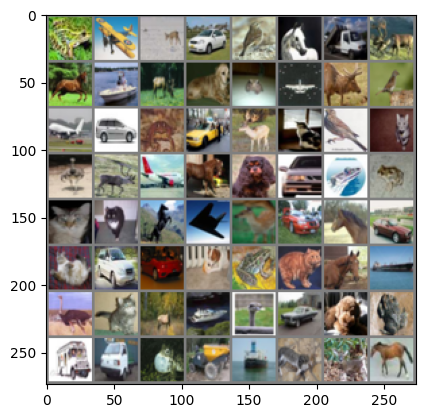

In [73]:
# Опишем требуемые трансформации
transform_train = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_val = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Загрузим и преобразуем датасет
training_loader, validation_loader = load(transform_train, transform_val, batch_size = 64)

# Посмотрим на примеры картинок
show_batch(training_loader)


In [74]:
# Обучим сеть
print('Training...')
train(model=model, trainloader=training_loader, criterion=loss_fn, optimizer=optimizer)

# Запустим валидацию и получим точность
print('Validation...')
accuracy = test(model=model, dataloader=validation_loader)
print(f'\nTest accuracy = {accuracy}')

Training...


  0%|          | 1/782 [00:00<01:39,  7.86it/s]

Step: 0, Loss: 0.10440294444561005


 14%|█▎        | 106/782 [00:03<00:23, 28.54it/s]

Step: 100, Loss: 0.0715862587094307


 26%|██▋       | 206/782 [00:07<00:20, 28.48it/s]

Step: 200, Loss: 0.06326013803482056


 39%|███▉      | 304/782 [00:11<00:25, 18.86it/s]

Step: 300, Loss: 0.15188764035701752


 52%|█████▏    | 405/782 [00:15<00:12, 29.20it/s]

Step: 400, Loss: 0.12552925944328308


 64%|██████▍   | 503/782 [00:19<00:12, 22.04it/s]

Step: 500, Loss: 0.3059541881084442


 77%|███████▋  | 603/782 [00:23<00:06, 27.41it/s]

Step: 600, Loss: 0.10079115629196167


 90%|█████████ | 706/782 [00:27<00:02, 27.19it/s]

Step: 700, Loss: 0.11279889196157455


100%|██████████| 782/782 [00:30<00:00, 25.69it/s]


Validation...


100%|██████████| 157/157 [00:04<00:00, 36.42it/s]


Test accuracy = 0.7862


## Нормализация - (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)

Files already downloaded and verified
Files already downloaded and verified


Training set has 50000 instances
Validation set has 10000 instances


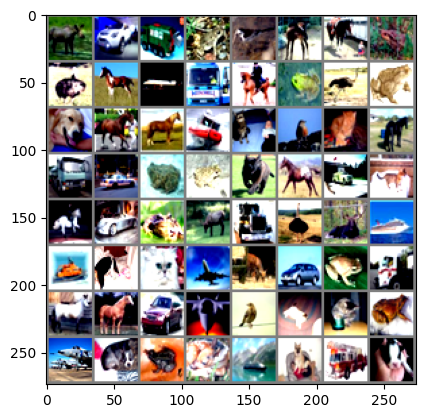

In [75]:
# Опишем требуемые трансформации
transform_train = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

transform_val = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Загрузим и преобразуем датасет
training_loader, validation_loader = load(transform_train, transform_val, batch_size = 64)

# Посмотрим на примеры картинок
show_batch(training_loader)

In [76]:
# Обучим сеть
print('Training...')
train(model=model, trainloader=training_loader, criterion=loss_fn, optimizer=optimizer)

# Запустим валидацию и получим точность
print('Validation...')
accuracy = test(model=model, dataloader=validation_loader)
print(f'\n\nTest accuracy = {accuracy}')

Training...


  0%|          | 2/782 [00:00<00:39, 19.68it/s]

Step: 0, Loss: 0.11506737023591995


 13%|█▎        | 104/782 [00:03<00:23, 28.63it/s]

Step: 100, Loss: 0.03872695937752724


 26%|██▋       | 206/782 [00:07<00:20, 28.01it/s]

Step: 200, Loss: 0.14601491391658783


 39%|███▉      | 305/782 [00:11<00:16, 28.83it/s]

Step: 300, Loss: 0.1581343114376068


 52%|█████▏    | 403/782 [00:14<00:13, 28.97it/s]

Step: 400, Loss: 0.13986742496490479


 64%|██████▍   | 503/782 [00:18<00:12, 22.32it/s]

Step: 500, Loss: 0.2222796082496643


 77%|███████▋  | 606/782 [00:22<00:06, 28.65it/s]

Step: 600, Loss: 0.038882046937942505


 90%|█████████ | 705/782 [00:26<00:02, 26.87it/s]

Step: 700, Loss: 0.06276160478591919


100%|██████████| 782/782 [00:28<00:00, 26.98it/s]


Validation...


100%|██████████| 157/157 [00:04<00:00, 38.78it/s]



Test accuracy = 0.6912


## Torchvision. Попытка №1

Files already downloaded and verified
Files already downloaded and verified
Training set has 50000 instances
Validation set has 10000 instances


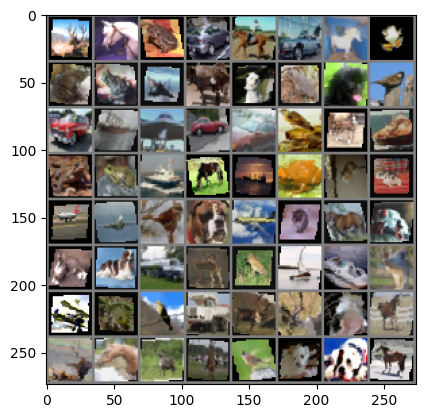

In [77]:
# Опишем требуемые трансформации
transform_train = transforms.Compose(
    [transforms.Resize((32,32)),  #resises the image so it can be perfect for our model.
     transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
     transforms.RandomRotation(10),     #Rotates the image to a specified angel
     transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
     transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
    ])

transform_val = transforms.Compose(
    [transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Загрузим и преобразуем датасет
training_loader, validation_loader = load(transform_train, transform_val, batch_size = 64)

# Посмотрим на примеры картинок
show_batch(training_loader)

In [78]:
# Обучим сеть
print('Training...')
train(model=model, trainloader=training_loader, criterion=loss_fn, optimizer=optimizer)

# Запустим валидацию и получим точность
print('Validation...')
accuracy = test(model=model, dataloader=validation_loader)
print(f'\n\nTest accuracy = {accuracy}')

Training...


  0%|          | 2/782 [00:00<01:08, 11.42it/s]

Step: 0, Loss: 1.954383373260498


 13%|█▎        | 103/782 [00:09<00:56, 12.08it/s]

Step: 100, Loss: 0.9247931838035583


 26%|██▌       | 203/782 [00:20<00:52, 11.04it/s]

Step: 200, Loss: 0.5576171875


 39%|███▊      | 302/782 [00:28<00:56,  8.57it/s]

Step: 300, Loss: 0.9683420658111572


 51%|█████▏    | 402/782 [00:37<00:32, 11.86it/s]

Step: 400, Loss: 0.6697128415107727


 64%|██████▍   | 502/782 [00:47<00:23, 12.10it/s]

Step: 500, Loss: 0.663518488407135


 77%|███████▋  | 602/782 [00:56<00:15, 11.94it/s]

Step: 600, Loss: 0.656173825263977


 90%|████████▉ | 702/782 [01:04<00:07, 10.99it/s]

Step: 700, Loss: 0.6414062976837158


100%|██████████| 782/782 [01:13<00:00, 10.68it/s]


Validation...


100%|██████████| 157/157 [00:04<00:00, 33.25it/s]



Test accuracy = 0.8135
